# Hyperasの練習

*20170715 Mitsuhiro Ito*


* (https://github.com/maxpumperla/hyperas/tree/master/examples)


---

# 1. 前準備

In [33]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [34]:
import sys
from utils import save_model_viz, save_weights, save_hist, plot_hist
from utils import load_mnist_3D

In [35]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import uniform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# 2. 画像ファイルの入手


犬猫データはKaggleからゲットしました  
登録がめんどくさいです  
https://www.kaggle.com/c/dogs-vs-cats/data


次に画像ファイルをtrain用1000枚、validation用400枚に分けます

In [3]:
import os

In [ ]:
source_dir = "/Users/mitsuhiro/Work/train"　#画像ファイルへのpath

In [ ]:
os.makedirs("%s/data" % "/Users/mitsuhiro/Work")　#train、valid用のフォルダを順次作成
data_dir = "/Users/mitsuhiro/Work/data"

In [ ]:
os.makedirs("%s/train" % data_dir)
os.makedirs("%s/valid" % data_dir)
train_dir = "/Users/mitsuhiro/Work/data/train"
valid_dir = "/Users/mitsuhiro/Work/data/valid"

In [ ]:
os.makedirs("%s/dogs" % train_dir)
os.makedirs("%s/cats" % train_dir)
os.makedirs("%s/dogs" % valid_dir)
os.makedirs("%s/cats" % valid_dir)

In [ ]:
for i in range(1000):　#train用画像ファイルを移動
    os.rename("%s/dog.%d.jpg" % (source_dir, i + 1),
              "%s/dogs/dog%04d.jpg" % (train_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, i + 1),
              "%s/cats/cat%04d.jpg" % (train_dir, i + 1))

In [ ]:
ls "/Users/mitsuhiro/Work/data/train/cats"

In [ ]:
for i in range(400):#valid用画像ファイルを移動
    os.rename("%s/dog.%d.jpg" % (source_dir, 1000 + i + 1),
              "%s/dogs/dog%04d.jpg" % (valid_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, 1000 + i + 1),
              "%s/cats/cat%04d.jpg" % (valid_dir, i + 1))


こんな感じになりました

    data/
        train/
              dogs/
                  dog.0001.jpg  ...  dog.1000.jpg
              cats/
                  cat.0001.jpg  ...  cat.1000.jp
                
        valid/
              dogs/
                  dog.0001.jpg  ...  dog.0400.jpg
              cats/
                　cat.0001.jpg  ...  cat.0400.jpg
                
---

# 3. 画像データへ加工

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [8]:
generator = ImageDataGenerator(rescale=1.0 / 255) 

ImageDataGeneratorによりリアルタイムに，画像データを生成する  
引数にはいろいろあるがrescaleなしで4-1.のCNNをやった場合、val_actが0.5付近から全然増えない...

ImageDataGenerator参考
https://keras.io/ja/preprocessing/image/


In [9]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


このgeneratorに渡せばデータ化してくれる

---




# 4.1 モデル構築＆評価　CNN

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [26]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
RUN_ID = 'CNN'
save_model_viz(RUN_ID, model)

In [29]:
batch_size = 16
hist = model.fit_generator(train_generator, 
                    steps_per_epoch = 2000 // batch_size, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = valid_generator,
                    validation_steps= 800 // batch_size)

save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)

Epoch 1/20
125/125 [==============================] - 6s - loss: 0.6948 - acc: 0.5325 - val_loss: 0.6853 - val_acc: 0.6200

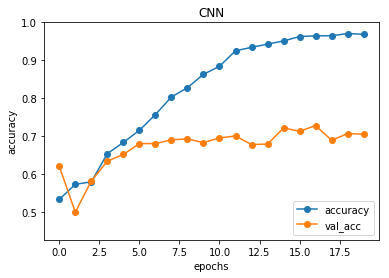

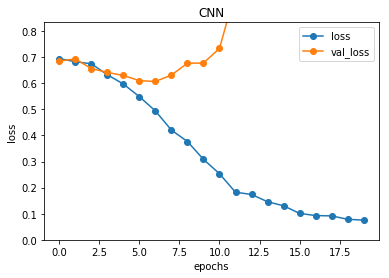

In [30]:
plot_hist(RUN_ID)

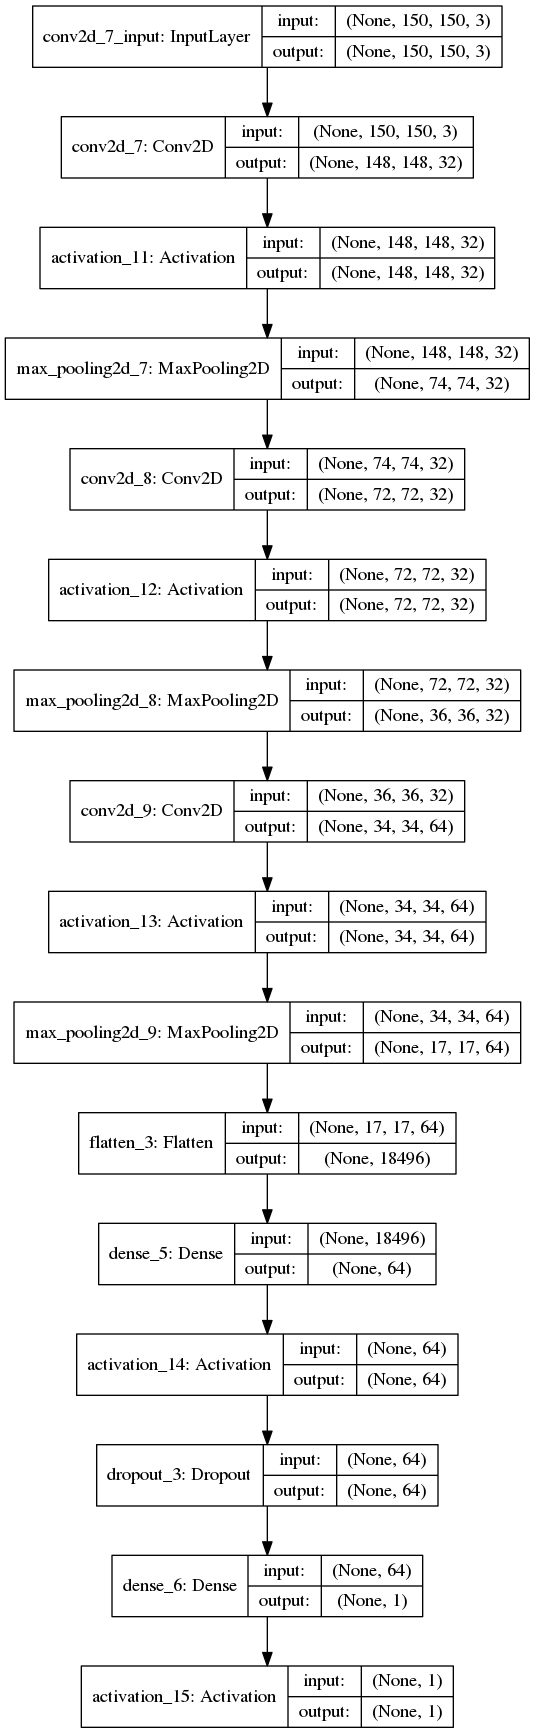

In [31]:
from IPython.display import Image
Image("model/CNN_vis.png", width=200)

# 5. Hyperas使用

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [37]:
def data():
    datagen = ImageDataGenerator(rescale=1.0 / 255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    train_generator = datagen.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)

    valid_generator = datagen.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)
    return train_generator, valid_generator

In [38]:
def model(train_generator, valid_generator):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    batch_size = 16
    hist = model.fit_generator(train_generator, 
                    steps_per_epoch = 2000 // batch_size, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = valid_generator,
                    validation_steps= 800 // batch_size)

    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [45]:
train_generator, valid_generator = data()

best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='20170714_hyperas1'
                                      )

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


SyntaxError: invalid syntax (<unknown>, line 66)

In [ ]:
RUN_ID = 'CNN_hyp'
save_model_viz(RUN_ID, model)

In [ ]:
save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)